In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
import lightgbm as lgb

In [2]:
!pip install -q optuna

In [3]:
from sklearn.model_selection import train_test_split
import optuna

In [4]:
df = pd.read_csv(r"/kaggle/input/restaurant-revenue-prediction/train.csv.zip")

In [5]:
df.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [6]:
df = df.drop(columns=['Id', 'Open Date'])

In [7]:
df

,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,...,3.0,5,1,3,2,3,4,3,3,4316715.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,Trabzon,Other,FC,2,3.0,3.0,5.0,4,2,4,...,3.0,0,0,0,0,0,0,0,0,5787594.0
133,İzmir,Big Cities,FC,4,5.0,4.0,4.0,2,3,5,...,3.0,0,0,0,0,0,0,0,0,9262754.0
134,Kayseri,Other,FC,3,4.0,4.0,4.0,2,3,5,...,3.0,0,0,0,0,0,0,0,0,2544857.0
135,İstanbul,Big Cities,FC,4,5.0,4.0,5.0,2,2,5,...,3.0,0,0,0,0,0,0,0,0,7217634.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 41 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        137 non-null    object 
 1   City Group  137 non-null    object 
 2   Type        137 non-null    object 
 3   P1          137 non-null    int64  
 4   P2          137 non-null    float64
 5   P3          137 non-null    float64
 6   P4          137 non-null    float64
 7   P5          137 non-null    int64  
 8   P6          137 non-null    int64  
 9   P7          137 non-null    int64  
 10  P8          137 non-null    int64  
 11  P9          137 non-null    int64  
 12  P10         137 non-null    int64  
 13  P11         137 non-null    int64  
 14  P12         137 non-null    int64  
 15  P13         137 non-null    float64
 16  P14         137 non-null    int64  
 17  P15         137 non-null    int64  
 18  P16         137 non-null    int64  
 19  P17         137 non-null    i

In [9]:
y = df['revenue']
X = df.drop(columns='revenue')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  train_size=0.75,
                                                  random_state=42)

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [12]:
num_columns = X.select_dtypes(include="number").columns
cat_columns = X.select_dtypes(include="object").columns


num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
    )

cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ('encoder', OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
           ])  

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_columns),
        ("cat", cat_transformer, cat_columns),
    ]
)

preprocessor.set_output(transform='pandas')
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21',
       'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31',
       'P32', 'P33', 'P34', 'P35', 'P36', 'P37'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['City', 'City Group', 'Type'], dtype='object'))])

In [13]:
X_train = preprocessor.fit_transform(X_train)

X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [14]:
from sklearn import metrics


def objective(trial):

  params = {
        "objective": "mse",
        "verbosity": -1,
        "n_estimators": 30,
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1.0, log=True),
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-2, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-2, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 100),
  }


  model = lgb.LGBMRegressor(**params)
    
  model.fit(X_train, y_train)

  y_pred = model.predict(X_val)
  r2 = metrics.r2_score(y_val, y_pred)

  return r2

In [15]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[LightGBM] [Warning] lambda_l2 is set=0.21903278592846148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21903278592846148
[LightGBM] [Warning] lambda_l1 is set=2.9565704574525054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9565704574525054
[LightGBM] [Warning] lambda_l2 is set=1.4467448913184286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4467448913184286
[LightGBM] [Warning] lambda_l1 is set=0.8835367807226171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8835367807226171
[LightGBM] [Warning] lambda_l2 is set=2.4509936132542873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4509936132542873
[LightGBM] [Warning] lambda_l1 is set=0.3291158293222485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3291158293222485
[LightGBM] [Warning] lambda_l2 is set=0.010089255969055057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010089255969055057
[LightGBM] [Warning] lambda_l1 is set=0.7894529374022194, r

In [16]:
best_params = study.best_params

In [17]:
best_params

{'learning_rate': 0.4936275860667031,
 'boosting_type': 'gbdt',
 'lambda_l1': 9.769782525841663,
 'lambda_l2': 0.1786307767981292,
 'num_leaves': 55}

In [18]:
study.best_value

0.049171299247656286

In [19]:
model = lgb.LGBMRegressor(**best_params,
                          verbose=-1)

model.fit(X_train, y_train,
          eval_set=[(X_test, y_test), (X_train, y_train)],
          eval_metric='mae')

[LightGBM] [Warning] lambda_l1 is set=9.769782525841663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.769782525841663
[LightGBM] [Warning] lambda_l2 is set=0.1786307767981292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1786307767981292
[1]	training's l1: 1.23194e+06	training's l2: 2.62125e+12	valid_0's l1: 2.01768e+06	valid_0's l2: 1.2056e+13
[2]	training's l1: 1.21421e+06	training's l2: 2.53739e+12	valid_0's l1: 2.02375e+06	valid_0's l2: 1.18565e+13
[3]	training's l1: 1.18835e+06	training's l2: 2.41956e+12	valid_0's l1: 2.04396e+06	valid_0's l2: 1.16309e+13
[4]	training's l1: 1.17071e+06	training's l2: 2.29294e+12	valid_0's l1: 2.04511e+06	valid_0's l2: 1.20474e+13
[5]	training's l1: 1.15001e+06	training's l2: 2.25744e+12	valid_0's l1: 2.07142e+06	valid_0's l2: 1.22537e+13
[6]	training's l1: 1.13928e+06	training's l2: 2.19709e+12	valid_0's l1: 2.12196e+06	valid_0's l2: 1.25398e+13
[7]	training's l1: 1.12519e+06	training's l2: 2.13922e+12	valid_0's l1: 2.09

LGBMRegressor(lambda_l1=9.769782525841663, lambda_l2=0.1786307767981292,
              learning_rate=0.4936275860667031, num_leaves=55, verbose=-1)

In [20]:
def get_metrics(y_true, y_pred, name="model"):
  df = pd.DataFrame()

  df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2", name] = metrics.r2_score(y_true, y_pred)

  return df.round(2)

In [21]:
all_metrics = pd.DataFrame()

all_metrics["train"] = get_metrics(y_train, model.predict(X_train))
all_metrics["test"] = get_metrics(y_test, model.predict(X_test))

all_metrics

,train,test
MAE,651196.43,2294462.36
RMSE,902355.41,3720049.44
R2,0.72,-0.13


In [22]:
optuna.visualization.plot_param_importances(study)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

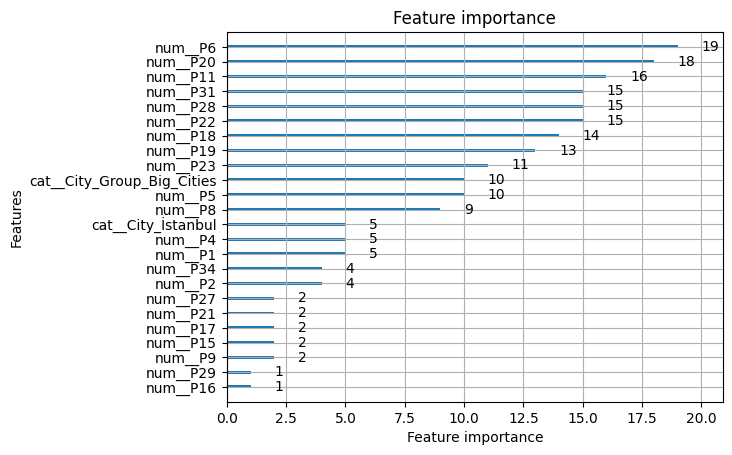

In [23]:
lgb.plot_importance(model)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

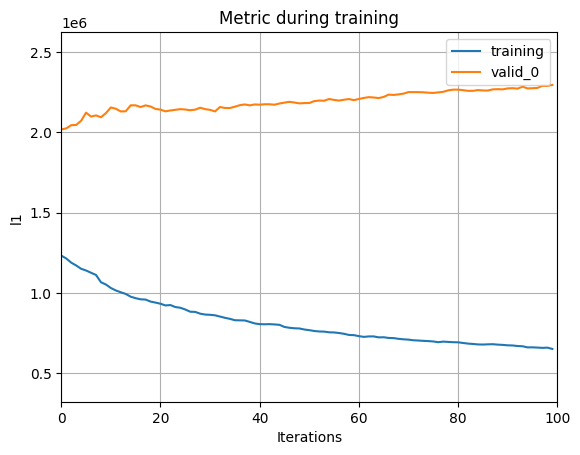

In [24]:
lgb.plot_metric(model,
                metric='l1')